In [1]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 44.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.1 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.0
    Uninstalling packaging-24.0:
      Successfully uninstalled packaging-24.0


In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import streamlit as st
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
wine_dataset = 'https://media.githubusercontent.com/media/MaryPetrichenko/wine_project/main/winemag-data-130k-v2.csv'
df = pd.read_csv(wine_dataset)

In [4]:
df.head()

,id,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [5]:
df.dtypes

id                         int64
country                   object
description               object
designation               object
points                     int64
price                    float64
province                  object
region_1                  object
region_2                  object
taster_name               object
taster_twitter_handle     object
title                     object
variety                   object
winery                    object
dtype: object

In [6]:
df[['title']].nunique()

title    118840
dtype: int64

In [7]:
df[['country']].nunique()

country    43
dtype: int64

In [8]:
df[['variety']].nunique()

variety    707
dtype: int64

In [9]:
df[['variety']].value_counts()

variety                 
Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
                            ...  
Tempranillo-Malbec              1
Malbec-Carménère                1
Malagouzia-Chardonnay           1
Tempranillo-Tannat              1
Žilavka                         1
Length: 707, dtype: int64

In [10]:
df.isnull().sum()

id                           0
country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

In [11]:
# Create a column that combines wine description, title, province and variety.
cols = ['description', 'variety', 'province', 'title']
df['compound_description'] = df.apply(lambda row: ' '.join(str(row[col]) for col in cols), axis=1)

In [12]:
df['compound_description'][0]

"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity. White Blend Sicily & Sardinia Nicosia 2013 Vulkà Bianco  (Etna)"

In [13]:
def country_fill(df):
  """
  The function takes first words in 'title' column before digits representing the year for the rows with null values in 'country' column
  and searches through the dataframe in other rows to get the country and fills null values if found any
  """

  pattern = r'^(.*?)(?=\b\d{4}\b)'  #find the first words before digits
  titles = list(df[df.country.isnull()].title) # list of titles with null values as countries
  title_country_dict = {} # a dictionary to keep track of matching titles and countries
  for title in titles:
    match = re.search(pattern, title)
    countries = [] # a list of found countries
    try:
      matched_string = match.group()
      mask = df['title'].str.contains(matched_string, case=False, na=False)
      countries = list(set(df[mask][df[mask]['country'].notnull()].country)) # a list of unique country values
      if len(countries)==1:
        title_country_dict[matched_string] = countries[0]
    except:
      AttributeError

  for key, value in title_country_dict.items():
    mask = df['title'].str.contains(key, case=False, na=False)
    df.loc[mask, 'country'] = df.loc[mask, 'country'].fillna(value) # replaces all nulls with the found country names


In [14]:
country_fill(df)

In [15]:
df.isnull().sum()

id                           0
country                     29
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
compound_description         0
dtype: int64

In [16]:
df.dropna(subset =['country', 'variety'], inplace = True)

In [17]:
tfidf = TfidfVectorizer(stop_words='english')

In [18]:
def split_df(df: pd.DataFrame, chunk_size: int) -> list[pd.DataFrame]:
    '''
    Split the data into chunks of specified size
    '''

    chunks = []
    pointer = 0
    while pointer < len(df):
        # Correct chunk_size for the last chunk
        if pointer + chunk_size > len(df):
            chunk_size = len(df) - pointer

        # Create a chunk and add it to the list
        chunk = df[pointer : pointer + chunk_size]
        chunks.append(chunk)

        # Increment the pointer
        pointer += chunk_size

    return chunks

In [19]:
def choose_wine (data, tfidf, prompt, chunk_size = 10000, n_similar = 5):

    selection = {}

    # Divide the dataset by chunks of less than chunk_size (10,000 by default)
    portions = split_df(data, chunk_size)

    for portion in portions:
        # Convert description series to list
        p = list(portion['compound_description'])

        # Add the prompt to each portion of data
        p.append(prompt)

        # Create a matrix and calculate the kernel
        matrix = tfidf.fit_transform(p)
        cosine_sim = linear_kernel(matrix)

        # Take the last line of scores which corresponds to the prompt and sort it
        sim_scores = list(enumerate(cosine_sim[-1]))
        sim_scores = sorted(sim_scores, key = lambda x: x[1],
                            reverse = True)[1:n_similar + 1]

        # Thake dataset indices from the selected scores
        for idx, score in sim_scores:
            wine_idx = portion.index[idx]
            selection[wine_idx] = score

    selected_wines = pd.DataFrame(
        list(selection.items()), columns = ['index', 'score'])
    selected_wines['index'] = selected_wines['index'].astype(int)
    selected_wines = selected_wines.merge(df[['title', 'description', 'variety', 'winery']], left_on='index', right_index=True)
    selected_wines.sort_values('score', ascending = False, inplace = True)

    return selected_wines






In [20]:
# prompt = 'pinot red blackcurrant strong'
# selected = choose_wine(df, tfidf, prompt)
# selected[['title', 'description']].head(5)

In [21]:
# for index, wine in selected.iloc[:10].iterrows():
#     print(f'title:\t{wine["title"]}')
#     print(f'descr:\t{wine["description"]}')
#     print(" ")

In [22]:
def check_if_any_of_list(row, columns, lst):
    for col in columns:
        try:
            if any(item.lower() in row[col].lower() for item in lst):
                return True
        except:
            continue
    return False

def get_wine_type(row, column, wine_types):
    for key, value in wine_types.items():
        if check_if_any_of_list(row, [column], value):
            return key
    return None


In [23]:
# Colours of wine

red = ['pinot noir', 'st. laurent,', 'zweigelt', 'gamay', 'sangiovese', 'garnacha', 'syrah', 'malbec', 'mourvèdre', 'cabernet sauvignon', 'merlot', 'nebbiolo',
       'tempranillo-merlot', 'red blend', 'frappato', 'nerello mascalese', "nero d'avola", 'bordeaux-style red blend', 'tempranillo blend', 'portuguese red', 'rhône-style red blend',
       'tempranillo', 'cabernet merlot', 'shiraz', 'petite sirah', 'sangiovese grosso', 'corvina, rondinella, molinara', 'carmenère', 'grenache', 'barbera', 'dolcetto',
       'montepulciano', 'pinot nero', 'blaufränkisch', 'aglianico', 'mencía', 'touriga nacional', 'tinta de toro', 'tannat', 'petit verdot', 'monastrell', 'cabernet sauvignon-merlot',
       'pinotage', 'bonarda', 'sagrantino', 'cabernet sauvignon-syrah', 'tinto fino', 'malbec-merlot', 'st. laurent', 'negroamaro', 'cabernet blend', 'lagrein', 'carignan','spätburgunder',
       'provence red blend', 'austrian red blend', 'malbec-cabernet sauvignon', 'syrah-grenache', 'tempranillo-cabernet sauvignon', 'alicante bouschet', 'grenache-syrah', 'prugnolo gentile',
       'cabernet sauvignon-carmenère', 'graciano', 'pedro ximénez', 'shiraz-cabernet sauvignon', 'shiraz-viognier', 'syrah-cabernet sauvignon', 'saperavi', 'merlot-cabernet sauvignon',
       'lemberger', 'castelão', 'xinomavro', 'claret', 'teroldego', 'tempranillo-garnacha', 'tannat-cabernet', 'petite verdot', 'carignane', 'touriga nacional-cabernet sauvignon',
       'dornfelder', 'charbono', 'cabernet sauvignon-shiraz', 'trincadeira', 'baga', 'abouriou', 'merlot-cabernet franc', 'cannonau', 'bobal', 'schiava', 'gamay noir', 'corvina', 'cabernet sauvignon-cabernet franc',
       'port', 'primitivo', 'cabernet franc-merlot', 'syrah-mourvèdre', 'monastrell-syrah', 'malbec-syrah', 'touriga nacional blend', 'nero di troia', 'tinto del pais', 'pinot noir-gamay',
       'piedirosso', 'chambourcin', 'cabernet sauvignon-malbec', 'syrah-viognier', 'plavac mali', 'grenache-carignan', 'negrette', 'alfrocheiro', 'baco noir', 'syrah-petite sirah',
       'tannat-cabernet franc', 'malbec-tannat', 'pinot meunier', 'raboso', 'cabernet franc-cabernet sauvignon', 'syrah-cabernet', 'kalecik karasi', 'norton', 'roter veltliner', 'roter']

white = ['pinot grigio', 'albarino', 'vinho verde', 'muscadet', 'sauvignon blanc', 'unoaked chardonnay', 'chenin blanc', 'chardonnay', 'viognier', 'marssanne', 'portuguese white',
         'riesling', 'pinot gris', 'gewürztraminer', 'white blend', 'grüner veltliner', 'cabernet franc', 'bordeaux-style white blend', 'rhône-style white blend', 'pinot blanc', 'sauvignon', 'albariño',
         'torrontés', 'verdejo', 'roussanne', 'turbiana', 'melon', 'vermentino', 'garganega', 'g-s-m', 'verdicchio', 'pinot bianco', 'fiano', 'vernaccia', 'grillo', 'alvarinho', 'sémillon',
         'grenache blanc', 'friulano', 'greco', 'viura', 'sherry', 'falanghina', 'ribolla gialla', 'arneis', 'austrian white blend', 'arinto', 'fumé blanc', 'sauvignon blanc-semillon', 'marsanne',
         'verdelho', 'petit manseng', 'moscatel', 'vidal blanc', 'pecorino', 'semillon-sauvignon blanc', 'trebbiano', 'sylvaner', 'alsace white blend', 'gros and petit manseng', 'weissburgunder',
         'müller-thurgau', 'malvasia', 'assyrtico', 'encruzado', 'traminer', 'silvaner', 'garnacha blanca', 'carricante', 'provence white blend', 'moschofilero', 'chardonnay-viognier', 'zibibbo', 'picolit',
         'aligoté', 'kerner', 'fernão pires', 'chenin blanc-chardonnay', 'rkatsiteli', 'insolia', 'inzolia', 'auxerrois', 'loureiro', 'scheurebe', 'gros manseng', 'catarratto', 'viognier-chardonnay',
         'rotgipfler', 'colombard', 'welschriesling', 'macabeo', 'jacquère', 'passerina', 'verdejo-viura', 'muskat ottonel', 'marsanne-roussanne', 'savagnin', 'tocai friulano', 'orange muscat', 'xarel-lo',
         'colombard-sauvignon blanc', 'palomino', 'picpoul', 'coda di volpe', 'antão vaz', 'assyrtiko', 'hondarrabi zuri', 'seyval blanc', 'moscato giallo', 'malvasia bianca', 'zierfandler',
         'sauvignon gris', 'pansa blanca', 'white riesling', 'chenin blanc-viognier', 'albana', 'moscato', 'muscat', 'furmint', 'tokaji']


rose = ['rose', 'rosé', 'rosato', 'rosado', 'portuguese rosé']

sparkling = ['lambrusco', 'glera', 'champagne blend', 'sparkling blend', 'prosecco', 'portuguese sparkling', 'sparkling', 'frizzante', 'lambrusco di sorbara', 'lambrusco grasparossa', 'sparkling']

wine_types = {
    'red': red,
    'white': white,
    'rose': rose,
    'sparkling': sparkling
}

for index, row in df.iterrows():
    # Check variety field
    type_by_variety = get_wine_type(row, 'variety', wine_types)

    # Correct the type if found in title or designation
    type_by_title = get_wine_type(row, 'title', wine_types)
    type_by_design = get_wine_type(row, 'designation', wine_types)

    # Assign the final type
    if type_by_design:
        df.at[index, 'type'] = type_by_design
    elif type_by_title:
        df.at[index, 'type'] = type_by_title
    elif type_by_variety:
        df.at[index, 'type'] = type_by_variety
    else:
        df.at[index, 'type'] = 'unknown'







In [24]:
df.loc[(df['variety'].str.contains('zinfandel', case=False, na=False)) &
       (df['designation'].str.contains('rosé', case=False, na=False, regex=True)), 'type'] = 'rose'
df.loc[(df['variety'].str.contains('zinfandel', case=False, na=False)) &
       (df['designation'].str.contains('white ', case=False, na=False, regex=True)), 'type'] = 'white'
df.loc[(df['variety'].str.contains('zinfandel', case=False, na=False)) &
       (df['type'].str.contains('unknown', case=False, na=False, regex=True)), 'type'] = 'red'

In [25]:
df['type'].value_counts()

red          77853
white        41449
rose          6207
sparkling     2862
unknown       1570
Name: type, dtype: int64

In [26]:
df = df[df['type'] != 'unknown']

In [27]:
# Create a list of stopwords that can be seen in any type of wine

type_custom_stopwords = ['wine', 'red', 'flavors', 'blend', 'rosé', 'acidity', 'de', 'sparkling', 'champagne', 'white', 'blanc', 'aromas', 'valley', 'tannins', 'palate', 'nv',
                        'finish', 'drink', 'california', 'provence', 'château', 'côtes', 'cabernet', 'pinot', 'sauvingon', 'vineyard', 'notes', 'brut', 'cava', 'cuvée', 'nose',
                        'noir', 'fruit', 'fruity', 'fruits', 'dry', 'texture', 'color', 'touch', 'well', 'balanced', 'character', 'sauvignon', 'offers', 'fine', 'full', 'fine',
                        'made', 'good', 'years', 'la', 'shows', 'sample','rich']

In [28]:
def most_frequent_words(df, colname, custom_stopwords, num):
    frequent_words = {}
    grouped = df.groupby(colname)['compound_description'].apply(' '.join)
    stop_words = set(nltk.corpus.stopwords.words('english'))

    # Add custom stop words that can be found in any type of wine and do not bring value to wine descriptions
    stop_words.update(custom_stopwords)

    for key, description in grouped.items():
        words = word_tokenize(description.lower())
        words = [word for word in words if word.isalnum() and len(word) > 1 and word not in stop_words]
        word_freq = Counter(words)

        n = num
        frequent_words[key] = word_freq.most_common(n)
    return frequent_words


In [29]:
type_words = most_frequent_words(df, 'type', type_custom_stopwords, 100)

In [30]:
for type, words in type_words.items():
    print(f"Wine Type: {type}")
    print("Most frequent words:")
    for word, freq in words:
        print(f"- {word}: {freq}")
    print()

Wine Type: red
Most frequent words:
- cherry: 25262
- black: 24752
- ripe: 16416
- berry: 14432
- spice: 14024
- syrah: 12910
- plum: 12877
- oak: 12522
- blackberry: 12264
- merlot: 11644
- 2012: 10671
- dark: 10665
- 2013: 9902
- soft: 8858
- 2010: 8511
- 2011: 8440
- 2014: 8377
- firm: 8253
- pepper: 8131
- raspberry: 8130
- chocolate: 7856
- malbec: 7598
- 2009: 7288
- bordeaux: 7157
- fresh: 7149
- juicy: 7070
- sweet: 6981
- washington: 6649
- vanilla: 6493
- zinfandel: 6421
- structure: 6049
- sangiovese: 6035
- tannic: 5971
- dried: 5922
- licorice: 5781
- estate: 5592
- tuscany: 5540
- light: 5519
- bright: 5505
- 2008: 5431
- spicy: 5172
- leather: 5098
- currant: 4986
- 2007: 4982
- tobacco: 4940
- herbal: 4897
- smooth: 4894
- herb: 4796
- dense: 4707
- di: 4672
- wood: 4656
- mendoza: 4517
- earthy: 4366
- cassis: 4341
- concentrated: 4235
- oregon: 4232
- structured: 4135
- new: 4115
- napa: 4100
- 2006: 4057
- cola: 4014
- give: 3977
- cherries: 3936
- also: 3915
- coffe

In [31]:
from wordcloud import WordCloud
from PIL import Image

In [32]:
type_words['red']

[('cherry', 25262),
 ('black', 24752),
 ('ripe', 16416),
 ('berry', 14432),
 ('spice', 14024),
 ('syrah', 12910),
 ('plum', 12877),
 ('oak', 12522),
 ('blackberry', 12264),
 ('merlot', 11644),
 ('2012', 10671),
 ('dark', 10665),
 ('2013', 9902),
 ('soft', 8858),
 ('2010', 8511),
 ('2011', 8440),
 ('2014', 8377),
 ('firm', 8253),
 ('pepper', 8131),
 ('raspberry', 8130),
 ('chocolate', 7856),
 ('malbec', 7598),
 ('2009', 7288),
 ('bordeaux', 7157),
 ('fresh', 7149),
 ('juicy', 7070),
 ('sweet', 6981),
 ('washington', 6649),
 ('vanilla', 6493),
 ('zinfandel', 6421),
 ('structure', 6049),
 ('sangiovese', 6035),
 ('tannic', 5971),
 ('dried', 5922),
 ('licorice', 5781),
 ('estate', 5592),
 ('tuscany', 5540),
 ('light', 5519),
 ('bright', 5505),
 ('2008', 5431),
 ('spicy', 5172),
 ('leather', 5098),
 ('currant', 4986),
 ('2007', 4982),
 ('tobacco', 4940),
 ('herbal', 4897),
 ('smooth', 4894),
 ('herb', 4796),
 ('dense', 4707),
 ('di', 4672),
 ('wood', 4656),
 ('mendoza', 4517),
 ('earthy', 43

In [55]:
mask = np.array(Image.open('/content/wine_mask.webp'))
mask = np.apply_along_axis(lambda x: 255 if x[0] == 0 else x[0], axis=2, arr=mask)

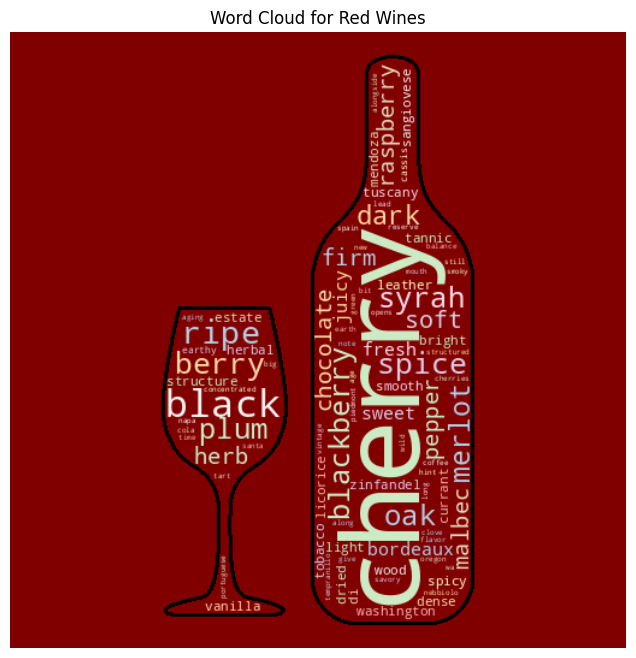

In [56]:
red_wine_words = ''
for word, freq in type_words['red']:
    red_wine_words += (word + ' ') * freq
wc = WordCloud(background_color="maroon", max_words=1000,
               max_font_size=90, contour_width=3,
               collocations=False, colormap = "Pastel1", mask = mask)
wc.generate(red_wine_words)
plt.figure(figsize = (15,8))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word Cloud for Red Wines')
plt.axis('off')
plt.show()

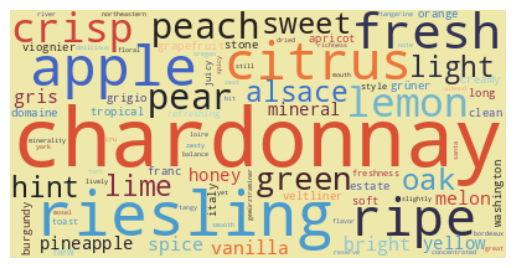

In [39]:
white_wine_words = ''
for word, freq in type_words['white']:
    white_wine_words += (word + ' ') * freq
wc = WordCloud(background_color="palegoldenrod", max_words=1000,
               max_font_size=90, contour_width=3,
               collocations=False, colormap = "icefire")
wc.generate(white_wine_words)
plt.figure()
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [41]:
# Identify most frequent varieties in our data
variety_counts = pd.DataFrame(df['variety'].value_counts().head(10))
variety_counts.reset_index(inplace=True)
variety_counts.columns = ['Variety', 'Count']
variety_counts

,Variety,Count
0,Pinot Noir,13272
1,Chardonnay,11751
2,Cabernet Sauvignon,9472
3,Red Blend,8936
4,Bordeaux-style Red Blend,6915
5,Riesling,5188
6,Sauvignon Blanc,4967
7,Syrah,4142
8,Rosé,3564
9,Merlot,3102


In [42]:
# get list of the varieties and indentify the words that describe it
top_varieties = list(variety_counts['Variety'])
top_varieties

['Pinot Noir',
 'Chardonnay',
 'Cabernet Sauvignon',
 'Red Blend',
 'Bordeaux-style Red Blend',
 'Riesling',
 'Sauvignon Blanc',
 'Syrah',
 'Rosé',
 'Merlot']

In [43]:
# Update the stop words list for describing the varieties
var_stop_words = ['bordeaux', 'merlo', 'franc', 'structure', 'napa','washington', 'burgundy', 'columbia', 'oregon', 'river', 'russian', 'hills', 'estate', 'santa',
                  'tuscany', 'alongside', 'di', 'york','attractive', 'grenache', 'marlborough','loire', 'sancerre', 'walla', 'wa', 'chardonnay', 'merlot', 'reserve',
                  'willamette', 'coast', 'sangiovese','merlot','syrah','sangiovese','riesling','mosel','alsace','new','domaine', 'opens', 'sonoma', 'yet', 'lakes',
                  'casablanca', 'structured', 'long', 'finger', 'county', 'barrel', 'rheingau']
variety_custom_stopwords = type_custom_stopwords + var_stop_words

In [44]:
top_var_df = df[df['variety'].isin(top_varieties)]
var_words = most_frequent_words(top_var_df, 'variety', variety_custom_stopwords, 20)

In [ ]:
for type, words in var_words.items():
    print(f"Wine Variety: {type}")
    print("Most frequent words:")
    for word, freq in words:
        print(f"- {word}: {freq}")
    print()

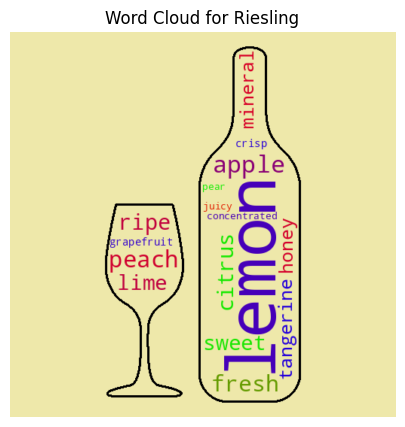

In [57]:
reisling_words = ''
for word, freq in var_words['Riesling']:
    reisling_words += (word + ' ') * freq

wc = WordCloud(background_color="palegoldenrod", max_words=1000, mask=mask,
               max_font_size=90, contour_width=3,
               collocations=False, colormap = "brg")
wc.generate(reisling_words)
plt.figure(figsize = (10,5))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word Cloud for Riesling')
plt.axis('off')
plt.show()

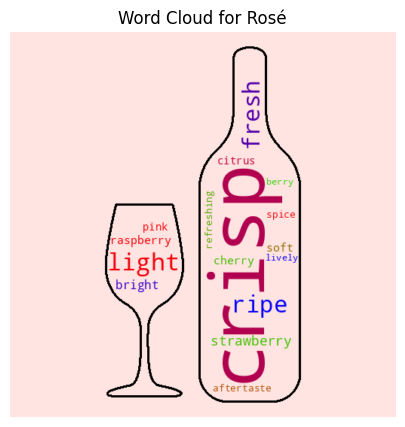

In [58]:
rose_words = ''
for word, freq in var_words['Rosé']:
    rose_words += (word + ' ') * freq



wc = WordCloud(background_color="mistyrose", max_words=1000, mask=mask,
               max_font_size=100, contour_width=3,
               collocations=False, colormap = "brg")
wc.generate(rose_words)
plt.figure(figsize = (10,5))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Word Cloud for Rosé')
plt.axis('off')
plt.show()

In [ ]:
# See the colormaps for font here:
# https://i.stack.imgur.com/x3SF8.png

# List of background colors:
# https://matplotlib.org/3.4.3/gallery/color/named_colors.html

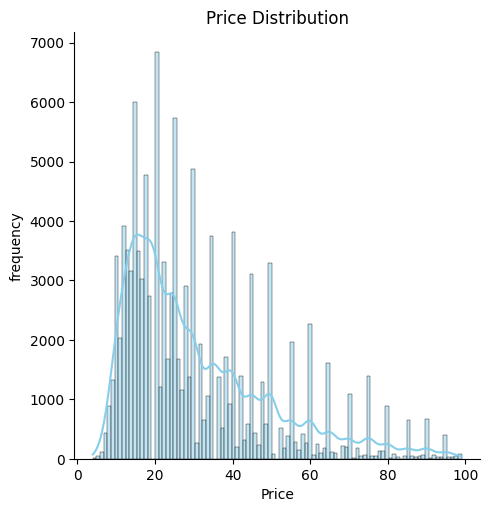

In [65]:
prices = df[df['price'] < 100]['price']

sns.displot(prices, kde=True, color='skyblue')

# Add labels and title
plt.xlabel('Price')
plt.ylabel('frequency')
plt.title('Price Distribution')

# Display the plot
plt.show()

In [61]:
df['price']

0          NaN
1         15.0
2         14.0
3         13.0
4         65.0
          ... 
129966    28.0
129967    75.0
129968    30.0
129969    32.0
129970    21.0
Name: price, Length: 128371, dtype: float64